# Peaks detection and features measurment

---

In [1]:
import sys
import os
import logging
import yaml

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import scipy
from scipy import signal
from scipy import stats
from scipy import ndimage

from sklearn import preprocessing

## Preprocessing & parameters

#### Custom func

In [13]:
def norm_prof_to_arr(input_df):
    """ Normilize raw Ca profiles in 0-1 range and convert data frame to numpy array
    Return:
        - np array (dims - [component, raw_prof, df_prof, norm_prof])
        - dict ({component:raw_prof})

    """
    output_arr = []
    output_dict = {}
    comp_list = np.array(input_df.comp.unique())
    for comp in comp_list:
        comp_raw_prof = np.array(input_df['profile_raw'][input_df['comp'] == comp])
        comp_df_prof = np.array(input_df['profile_ddf'][input_df['comp'] == comp])
        comp_norm_prof = preprocessing.minmax_scale(comp_raw_prof)
        output_arr.append([comp_raw_prof, comp_df_prof, comp_norm_prof])
        output_dict.update({comp:comp_raw_prof})
    return np.asarray(output_arr), output_dict

def ctrl_plot(input_df):
    # raw profiles view
    fig=px.line(input_df,
                y='profile_ddf',
                x='time',
                color='comp',
                animation_frame="comp",
                title='Individual components ΔF/F profiles')
    fig.update(layout_yaxis_range = [min(input_df.profile_ddf), max(input_df.profile_ddf)])
    fig.show()


def prof_peaks_plot(input_profile, peaks_i, peaks_prop, x_time=None, add_profile=None):
    """ SciPy find_peaks results for individual profile plotting,
    for 0-1 range scaling profile only

    """
    # features calc
    if x_time is None:
        x_time = np.linspace(0, input_profile.shape[0], input_profile.shape[0])
    prom = peaks_prop['prominences']
    prom_h = input_profile[peaks_i] - prom
    width_w = np.sort(np.asarray([*peaks_prop['left_bases'], *peaks_prop['right_bases']], dtype=int))
    width_pairs =  np.asarray(list(zip(peaks_prop['left_bases'], peaks_prop['right_bases'])), dtype=int)
    fwhm_y = peaks_prop['width_heights']
    fwhm_l = x_time[np.asarray(peaks_prop['left_ips'], dtype=int)]
    fwhm_r = x_time[np.asarray(peaks_prop['right_ips'], dtype=int)]

    # plotting
    plt.figure(figsize=(20, 8))
    plt.plot(x_time, input_profile)
    plt.plot(x_time[peaks_i], input_profile[peaks_i], 'x', color='red')
    plt.plot(x_time[width_w], input_profile[width_w], '.', color='red')
    plt.vlines(x=x_time[peaks_i], ymin=prom_h, ymax=input_profile[peaks_i], color='red')
    plt.hlines(y=fwhm_y, xmin=fwhm_l, xmax=fwhm_r, color='red')
    plt.hlines(y=.5, xmin=0, xmax=np.max(x_time), linestyles='--', color='k')
    plt.fill_between(x=x_time,
                     y1=input_profile,
                     y2=.5,
                     color='y',
                     alpha=.2,
                     where=input_profile>=.5)
    for peak_width in width_pairs:
        plt.fill_between(x= x_time[peak_width[0]:peak_width[1]], 
                         y1= input_profile[peak_width[0]:peak_width[1]], 
                         color= "red",
                         alpha= 0.2)
    if add_profile is not None:
        plt.plot(x_time, add_profile, color='g', alpha=.25)
    # plt.legend()
    plt.show()

def cascade_plot(input_df, time, line_dict, y_shift=0.5):
    """ prof_arr, [prof_num, prof_val] - 2d numpy array with dF/F profiles

    """
    list_ROI = np.array(input_df.comp.unique())
    time_bar = int(200 * (max(time)/len(time)) )

    plt.figure(figsize=(20, 8))
    
    shift = 0
    for num_ROI in list_ROI:
        prof_ROI = np.array(input_df['profile_ddf'][input_df['comp'] == num_ROI])
        plt.plot(time, prof_ROI+shift, alpha=.5, label=f'ROI {num_ROI}')
        shift += y_shift

    for line_name in line_dict:
        line_lim = line_dict[line_name]
        plt.plot(line_lim, [-0.4] * len(line_lim), label=line_name, linewidth=4)

    plt.vlines(x=[-20], ymin=[-0.2], ymax=[0.8], linewidth=3, color='k')
    plt.text(x=-30, y=-0.2, s="100% ΔF/F", size=15, rotation=90.)

    plt.hlines(y=[-0.75], xmin=[-10], xmax=[time_bar-10], linewidth=3, color='k')
    plt.text(x=30, y=-1.15, s="200 s", size=15)

    plt.axis('off')
    plt.legend(loc=2)
    plt.show()


#### Data uploading

In [9]:
samp_name = 'A0005'
samp_path = os.path.join(''.join(sys.path[0].split('neuro')), 'data_neuro', samp_name)

# sample YAML metadata file uploading
with open(f'{samp_path}/{samp_name}_meta.yaml') as f:
    samp_meta = yaml.safe_load(f)

# sample data frame uploading
pre_df = pd.read_csv(f'{samp_path}/{samp_name}_pre_comp_df.csv')
pre_arr, _ = norm_prof_to_arr(pre_df)
print(pre_arr.shape)
print(pre_df.head())
ctrl_plot(pre_df)

# post_path = f'{samp_path}/{samp_name}_post_comp.csv'

(13, 3, 1091)
  reg_name  indx      time  comp  profile_raw   profile_C  profile_ddf
0    A0005     0  0.000000     1   127.145808 -672.172026    -0.033848
1    A0005     1  0.556614     1   126.224847 -672.172026    -0.025963
2    A0005     2  1.113228     1   128.134824 -497.117256     0.004138
3    A0005     3  1.669841     1   128.001287 -558.015733    -0.013121
4    A0005     4  2.226455     1   127.169581 -597.728709    -0.013673


#### Sample global parameters, detection & measurment options

In [6]:
# time parameters (from meta file)
total_reg_t = samp_meta['Reg_time']
frame_time = total_reg_t / max(pre_df['indx'])
time_line = np.linspace(0, total_reg_t, num=max(pre_df['indx'])+1)

# treatment parameters (from meta file)
treatment_dict = {}
for samp in samp_meta['Events']:
    treat_name = f"{samp['Type']}_{samp['Freq']}"
    start_time = samp['Time']/1000
    end_time = start_time + samp['Duration']
    treatment_dict.update({treat_name:[start_time, end_time]})
application_lines_dict = {t:np.linspace(treatment_dict[t][0], treatment_dict[t][1]) for t in treatment_dict}

# detection options
min_distance_sec = 3
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

# prominence calc window option
wlen_sec = 30
wlen_frames = int(wlen_sec / frame_time)

# duration options
width_sec = [1, 200]  # [min, max]
width_frames = np.asanyarray([width_sec[0]/frame_time, width_sec[1]/frame_time], dtype=int)

plat_sec = [1, 500]  # [min, max]
plat_frames = np.asarray([plat_sec[0]/frame_time, plat_sec[1]/frame_time], dtype=int)
plat_frames[plat_frames == 0] = 1

#### Ctrl. ΔF/F profiles plot

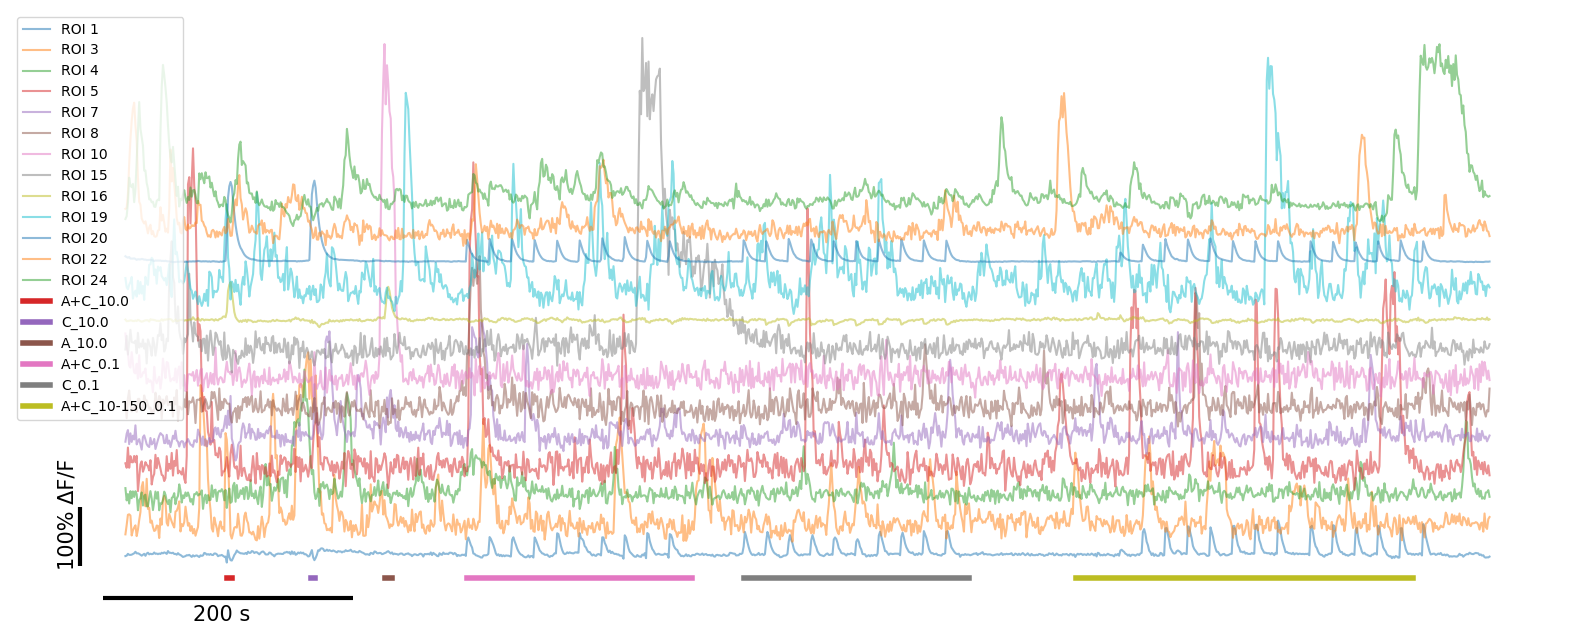

In [14]:
cascade_plot(pre_df, time_line, application_lines_dict)

## Peaks detection with custom detector

#### No convolution

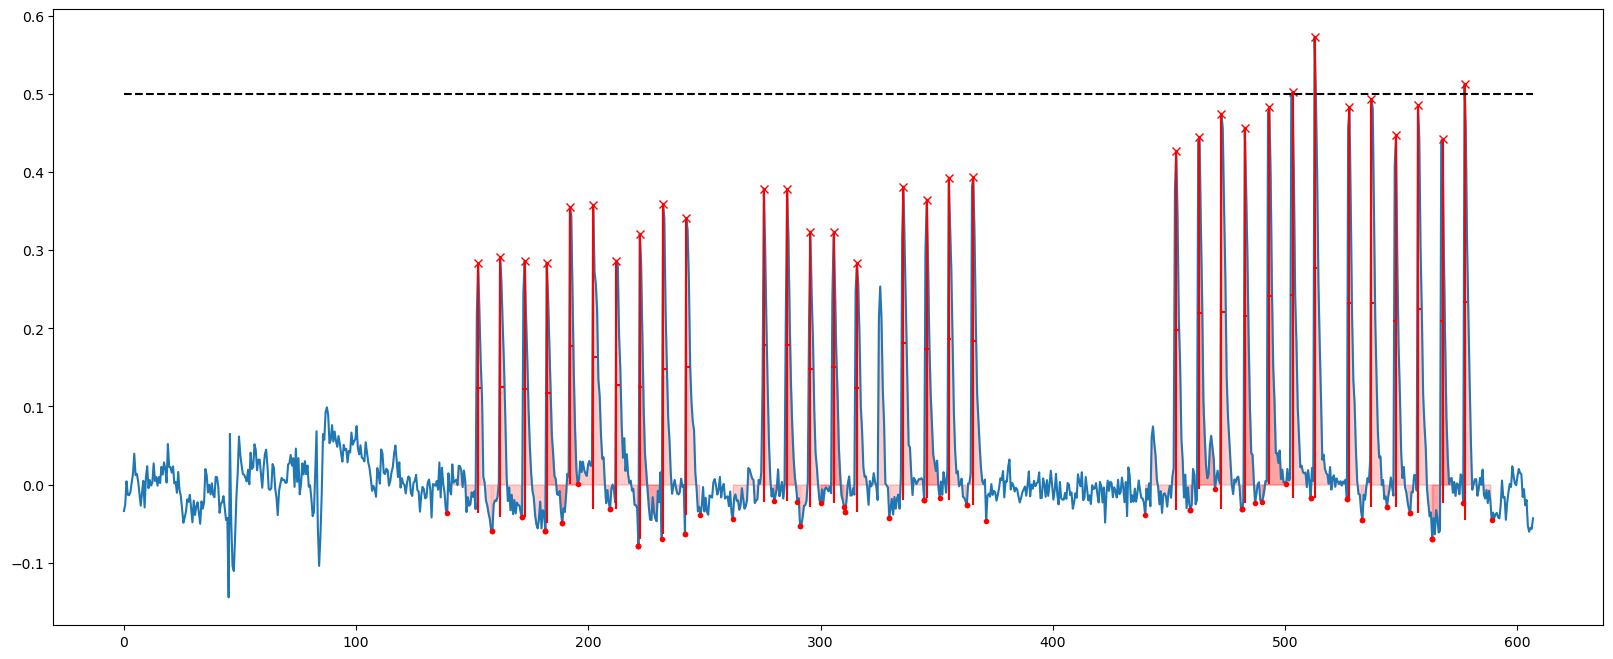

In [18]:
det_prof = pre_arr[0, 1]

peaks, properties = signal.find_peaks(det_prof,
                                      height=0.2,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=wlen_frames,
                                      prominence=0.3,
                                      rel_height=0.5,
                                      width=width_frames)

prof_peaks_plot(input_profile=det_prof, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=None)

#### Convolution

(3, 1091)


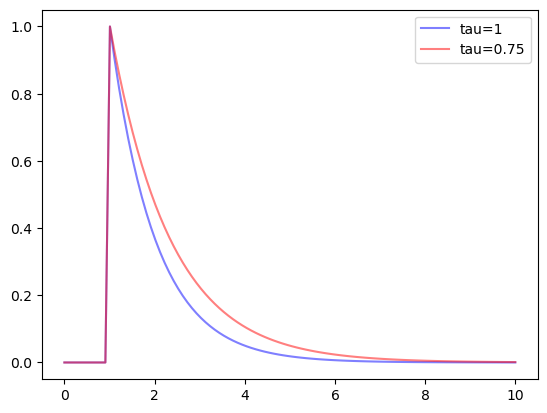

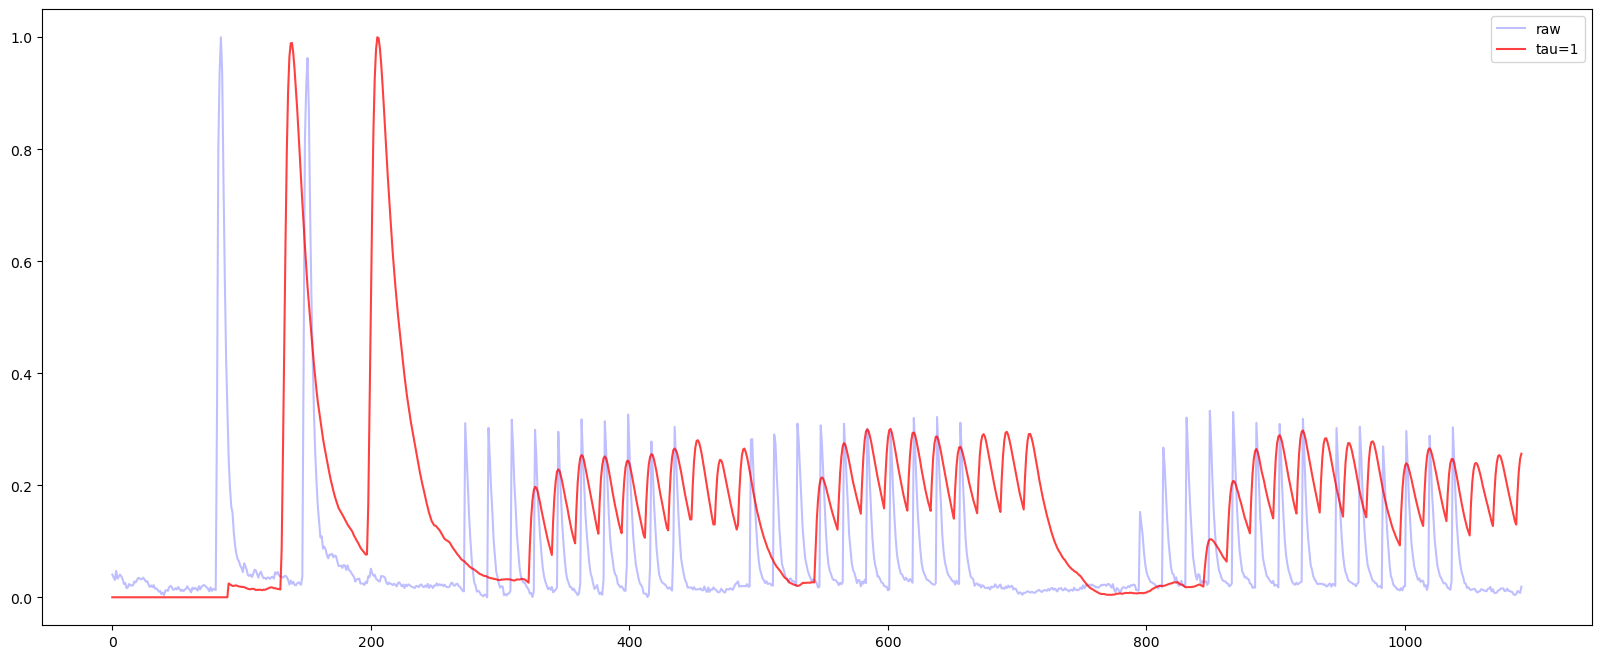

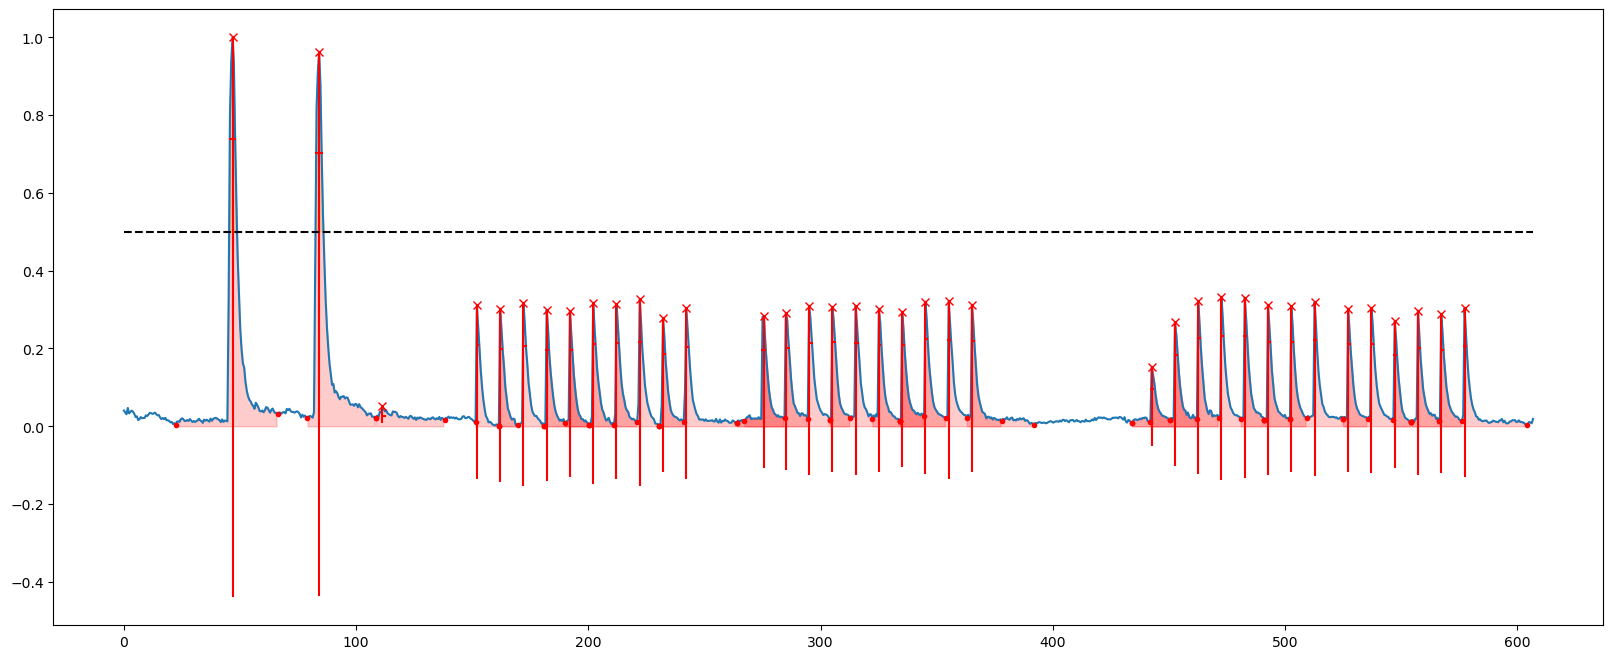

In [13]:
# kernel section
x = np.linspace(0, 10, 100)

# exp kernel
y = 1 / np.exp(np.linspace(0, 9, 90))
y = np.concatenate([np.zeros(10), y])

tau = 0.75
y_1 = 1 / np.exp(np.linspace(0, 9, 90) * tau)
y_1 = np.concatenate([np.zeros(10), y_1])

# square kernel
y_2 = np.zeros(100)
y_2[10:60] = 1


# conv section
one_comp_profile = pre_arr[11]  # <=================================
prof_raw = one_comp_profile[1]


print(one_comp_profile.shape)


conv_raw = ndimage.convolve1d(prof_raw, y_1)
conv_1 = ndimage.convolve1d(prof_raw, y_1)

# scaling 0-1
prof = preprocessing.minmax_scale(prof_raw)
conv = preprocessing.minmax_scale(conv_raw)

# convolved vector shift compensation
prof_max = np.argmax(prof[:int(prof.shape[0]/4)])
conv_max = np.argmax(conv[:int(conv.shape[0]/4)])
# conv_shift = prof_max - conv_max
# print(conv_shift)
conv = np.concatenate([np.zeros(90), conv[:-90]])

# debug plot
debug_plot = True
if debug_plot:
    # kernel plot
    plt.plot(x, y, color='b', alpha=.5, label='tau=1')
    plt.plot(x, y_1, color='r', alpha=.5, label=f'tau={tau}')
    plt.legend()
    plt.show()

    # conv plot
    plt.figure(figsize=(20, 8))
    plt.plot(prof, color='b', alpha=.25, label='raw')
    plt.plot(conv, color='r', alpha=.75, label='tau=1')

    plt.legend()
    plt.show()

# detection
peaks, properties = signal.find_peaks(prof_raw,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=100,
                                      prominence=0.04,
                                      rel_height=0.5,
                                      width=width_frames)

# peaks plot without plat det
prof_peaks_plot(input_profile=prof, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=None)

In [ ]:

# plateau peaks merging
plat_th = 0.5
bases_arr = np.asarray([conv[properties['left_bases']],conv[properties['right_bases']]]).T

if np.any(bases_arr < plat_th):
    bases_i_arr = np.asarray([properties['left_bases'],properties['right_bases']]).T
    bad_bases = np.asarray([np.zeros(2) if all(i<plat_th) else i for i in bases_arr])  # np.asarray([i for i in bases_arr if any(i>=0.5)])

    # plat extraction
    plat_i = np.asarray([True if any(b>=plat_th) else False for b in bases_arr])
    plat_mask,_ = ndimage.label(plat_i)
    plat_ends = [[bases_arr[plat_mask == p_n][0][0], bases_arr[plat_mask == p_n][-1][1]] for p_n in np.trim_zeros(np.unique(plat_mask))]  # plat ends extraction
    plat_ends_i = [[bases_i_arr[plat_mask == p_n][0][0], bases_i_arr[plat_mask == p_n][-1][1]] for p_n in np.trim_zeros(np.unique(plat_mask))]  # plat ends index extraction

    # print(plat_ends_i)
    # print(plat_ends)

    # plat features calc
    prom_win_scale = 2
    plat_prom_win = max([b[1]-b[0] for b in plat_ends_i]) * prom_win_scale
    plat_peaks = [np.argmax(conv[b[0]:b[1]])+b[0] for b in plat_ends_i]

    print(plat_ends_i)
    print(plat_prom_win)


    plat_prom = signal.peak_prominences(conv, plat_peaks, wlen=plat_prom_win)
    plat_w = signal.peak_widths(conv, plat_peaks, rel_height=0.5, prominence_data=plat_prom)

    print(plat_prom)

    # prop update
    # full_peaks = np.delete(peaks, plat_i)
    # full_peaks = np.concatenate((full_peaks, plat_peaks))
    peaks = np.concatenate((np.delete(peaks, plat_i), plat_peaks))

    properties.update({'prominences':np.concatenate((np.delete(properties['prominences'], plat_i), plat_prom[0]))})
    properties.update({'left_bases':np.concatenate((np.delete(properties['left_bases'], plat_i), plat_prom[1]))})
    properties.update({'right_bases':np.concatenate((np.delete(properties['right_bases'], plat_i), plat_prom[2]))})
    properties.update({'widths':np.concatenate((np.delete(properties['widths'], plat_i), plat_w[0]))})
    properties.update({'width_heights':np.concatenate((np.delete(properties['width_heights'], plat_i), plat_w[1]))})
    properties.update({'left_ips':np.concatenate((np.delete(properties['left_ips'], plat_i), plat_w[2]))})
    properties.update({'right_ips':np.concatenate((np.delete(properties['right_ips'], plat_i), plat_w[3]))})

# peaks plot with plat det
prof_peaks_plot(input_profile=conv, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=prof)

In [ ]:
class p_det():
    """ Detector class

    """
    def __init__(self):
        pass